In [18]:
import test_data
import train_data
import torch
from torch.utils import data as td
import data
from data import strawberry
import matplotlib.pyplot as plt

In [19]:

training_set = strawberry('train_data/')
test_set = strawberry('test_data/')

In [20]:
batch_size = 8
train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0}
testparams   = {'batch_size': 1,
               'shuffle': True,
               'num_workers': 0}

train_loader = td.DataLoader(training_set, **train_params)
test_loader = td.DataLoader(test_set,**testparams)

torch.Size([64, 64, 3])


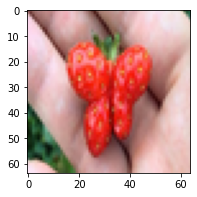

In [21]:
device = torch.device("cpu")

# Plot some training images
images = next(iter(test_loader))
plt.figure(figsize=(3,3))
print(images[0].shape)
plt.imshow(images[0].numpy())